In [1]:
import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras import Model
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization
import tensorflow.keras.backend as K

# Face Recognition Model

This notebook contains a model with a convolutional neural network (CNN) architecture, with the addition of residual blocks. The goal of the model is to learn a compact and discriminative embedding of face images, where similar faces have similar embeddings. 

the techniques used are based on Facenet 
- Using triplets of images to train the network (anchor, positive, negative)
- online triplet mining
- Residual blocks (ResNet)


The model is trained with the goal of minimizing the  loss between similar and dissimilar image pairs.


number of images from 3 classes: 163
images from class 0: 50
images from class 1: 48
images from class 2: 65


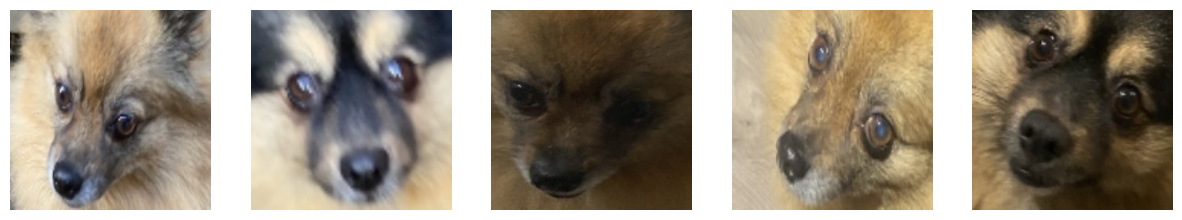

In [2]:
#loads training data
data_path = "data\\trainData"
X = []
y = []

image_class = 0
for folder in os.listdir(data_path):
    for file in os.listdir(data_path + "\\" + folder):
        X.append(os.path.join(data_path, folder, file))
        y.append(image_class)
    image_class += 1

print(f"number of images from {image_class} classes: {len(X)}")
print(f"images from class 0: {y.count(0)}")
print(f"images from class 1: {y.count(1)}")
print(f"images from class 2: {y.count(2)}")

#show 5 images on same plot
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    j = np.random.randint(len(X))
    img = cv2.imread(X[j])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()


#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
#make np arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [3]:

alpha = 0.3


#triplet loss calculates the loss of the model by measuring how well the model is able to learn the relationships between the anchor, positive, and negative samples in the triplet.
def triplet_loss(y_true,y_pred):
    #a = anchor, p = positive, n = negative
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    # ap = sum of squared differences between anchor and positive
    ap = K.sum(K.square(a-p),-1)
    # an = sum of squared differences between anchor and negative
    an = K.sum(K.square(a-n),-1)
    # return sum of relu(ap-an+alpha)
    return K.sum(tf.nn.relu(ap - an + alpha))

# triplet_acc calculates the accuracy of the model by measuring how well the model is able to learn the relationships between the anchor, positive, and negative samples in the triplet.
def triplet_acc(y_true,y_pred):
    #a = anchor, p = positive, n = negative
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    # ap = sum of squared differences between anchor and positive
    ap = K.sum(K.square(a-p),-1)
    # an = sum of squared differences between anchor and negative
    an = K.sum(K.square(a-n),-1)
    # returns 1 if ap + alpha < an, 0 otherwise.
    return K.less(ap+alpha,an)


# model architecture
The model takes as input a face image of size 256x256x3, and outputs a 128-dimensional embedding vector for each image. The embedding vector can be used for tasks such as face verification, clustering, and retrieval.

The model consists of:
- A convolutional layer with 16 filters, kernel size 7x7, stride 2x2, no bias, and ReLU activation
- Batch normalization
- Max pooling layer with pool size 3x3
- 5 residual blocks, each consisting of:
    - A convolutional layer with a variable number of filters, kernel size 3x3, stride 2x2, no bias, and ReLU activation
    - Batch normalization
    - A second convolutional layer with the same number of filters, kernel size 3x3, no bias, and ReLU activation
    - Batch normalization
    - A residual connection between the input and output of the second convolutional layer
- Global average pooling layer
- Flatten layer
- Dropout layer with a rate of 0.5
- Dense layer with 128 units and no bias
- L2 normalization

In [4]:
#embedding size is the size of the vector that will be used to represent the face
embeddings = 128
resnet_layers = [16,32,64,128,512]
img_size = (256, 256, 3)
inputs = Input(shape=img_size)

#model architecture
conv1 = Conv2D(16, (7, 7), (2, 2), use_bias=False, activation='relu', padding='same')(inputs)
norm1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((3,3))(norm1)

#residual blocks
for layer in resnet_layers:
    conv2 = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(pool1)
    norm2 = BatchNormalization()(conv2)
    conv3 = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(norm2)
    norm3 = BatchNormalization()(conv3)
    add1 = Add()([norm2,norm3])
    
    conv4 = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(add1)
    norm4 = BatchNormalization()(conv4)
    pool1 = Add()([add1,norm4])
    
#global average pooling
glob_avg_pool = GlobalAveragePooling2D()(pool1)
flatten = Flatten()(glob_avg_pool)
dropout = Dropout(0.5)(flatten)

# Dense layer with embeddings size
dense = Dense(embeddings, use_bias=False)(dropout)

# L2 normalization
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(dense)


model = Model(inputs,outputs)

model.compile(loss=triplet_loss, optimizer='adam', metrics=[triplet_acc])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 2352        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 42, 42, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

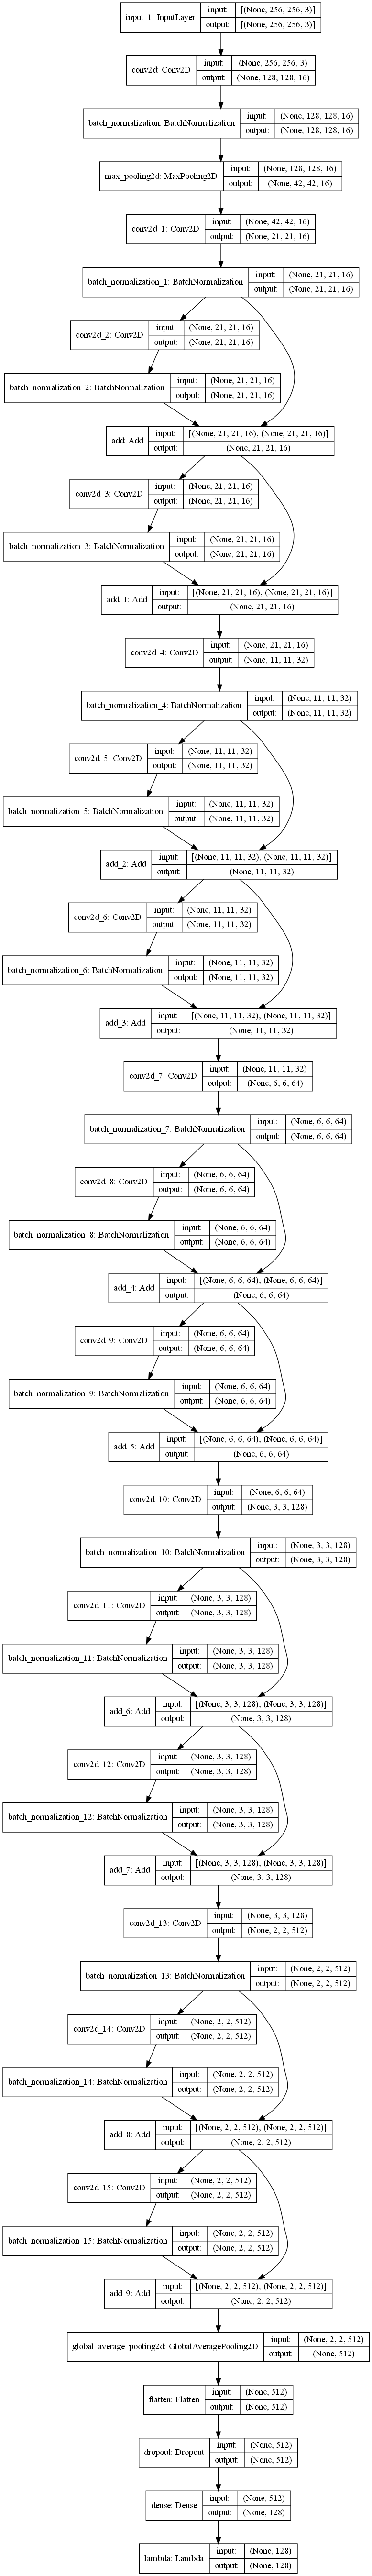

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

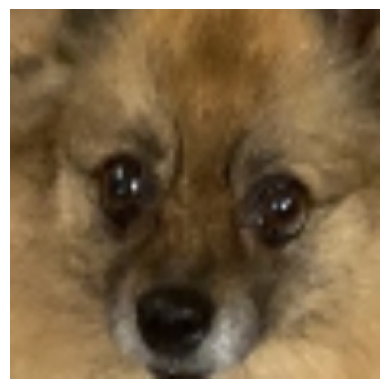

In [5]:
#----------------------UTILS----------------------#

#load images
def load_images(filenames):
    h,w,c = img_size
    images = []
    for image in filenames:
        img = cv2.imread(image)
        img = cv2.resize(img, (h,w))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        images.append(img)
    images = np.array(images)
    return images

#show 1 image
img = load_images([X[0]])
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [6]:
#---------------generate triplets for validating----------------#

def generate_triplets_for_validation(filenames, labels, triplets_count=21 * 3, batch_size=63):
    while True:
        X_triplet = []
        y_triplet = np.empty(triplets_count)
        classes = np.unique(labels)
        for i in range(0, triplets_count, 3):
            # Pick a class and choose two pictures from this class
            anchor_class = classes[np.random.randint(len(classes))]
            where_anchor_class = np.equal(labels, anchor_class)

            anchor_files = filenames[where_anchor_class]
            anchor_labels = labels[where_anchor_class]

            # Picks anchor and positive image from same class
            anchor_index = np.random.randint(len(anchor_files))
            positive_index = np.random.randint(len(anchor_files))

            while anchor_index == positive_index:
                positive_index = np.random.randint(len(anchor_files))

            X_triplet += [anchor_files[positive_index]]
            X_triplet += [anchor_files[anchor_index]]
            y_triplet[i] = anchor_labels[positive_index]
            y_triplet[i+1] = anchor_labels[anchor_index]

            # Pick a class for the negative picture
            negative_class = classes[np.random.randint(len(classes))]
            # Check if not same class
            while negative_class == anchor_class:
                negative_class = classes[np.random.randint(len(classes))]

            where_negative_class = np.equal(labels, negative_class)
            negative_files = filenames[where_negative_class]
            negative_labels = labels[where_negative_class]

            # Picks negative image from different class
            negative_index = np.random.randint(len(negative_files))

            X_triplet += [negative_files[negative_index]]
            y_triplet[i+2] = negative_labels[negative_index]

        X_triplet = load_images(X_triplet)
        yield (X_triplet, y_triplet)

In [7]:
#---------------generate triplets for training----------------#

#data augmentation
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

#uses datagen to transform images
def transform(images, datagen):
    for i in datagen.flow(images, batch_size=len(images), shuffle=False):
        return i

#generates predictions, and loads images
def batch_image_generator(filenames, batch_size=32):
    for i in range(0,len(filenames),batch_size):
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch 

#generates adaptive triplets for training

def generate_adaptive_triplets_for_training(filenames, labels, prediction, hard, tripls_cnt=21*3):
    
    # Check if triplets_count is a multiple of 3
    assert tripls_cnt%3 == 0
    
    classes = np.sort(np.unique(labels))
    triplets = []
    y_triplets = np.empty(tripls_cnt)
    pred_triplets = np.empty((tripls_cnt,prediction.shape[-1]))

    for i in range(0, tripls_cnt, 3): #3 is the step size
        picked_class = np.equal(labels,classes[np.random.randint(len(classes))])
        picked_files = filenames[picked_class]
        picked_labels = labels[picked_class]
        
        # Chooses the anchor image among this class randomly
        index_anchor = np.random.randint(len(picked_labels))
        
        #creates hard or soft triplets depending on the value of hard
        if hard: 
            #finds the index of the image in the class that is the most dissimilar to the anchor image
            dist_class = np.sum(np.square(prediction[picked_class]-prediction[picked_class][index_anchor]),axis=-1)
            index_positive = np.argmax(dist_class)
        else:
            #finds a random image in the class that is not the anchor image
            index_positive = np.random.randint(len(picked_labels))
            while index_anchor==index_positive:
                index_positive = np.random.randint(len(picked_labels))
               
        
        triplets += [picked_files[index_anchor]]
        y_triplets[i] = picked_labels[index_anchor]
        pred_triplets[i] = prediction[picked_class][index_anchor]
        triplets += [picked_files[index_positive]]
        y_triplets[i+1] = picked_labels[index_positive]
        pred_triplets[i+1] = prediction[picked_class][index_positive]
        
        # Computes the distance between the chosen image and the rest of the other classes
        other_classes = np.logical_not(picked_class)
        
        if hard:
            #finds the index of the image in the other classes that is the most similar to the anchor image
            dist_other = np.sum(np.square(prediction[other_classes]-prediction[picked_class][index_anchor]),axis=-1)
            index_negative = np.argmin(dist_other)
        else:
            index_negative = np.random.randint(len(filenames[other_classes]))
            
        triplets += [filenames[other_classes][index_negative]]
        y_triplets[i+2] = labels[other_classes][index_negative]
        pred_triplets[i+2] = prediction[other_classes][index_negative]

    return np.array(triplets), y_triplets, pred_triplets


#generator to select online hard triplets for training
#online means that the hard triplets are selected from the current batch of images instead of the whole dataset
def online_adaptive_triplet_generator(filenames, labels, model, loss, batch_size=63, hard_triplet_ratio = 0, hard_triplets_count = 0):  
    while True:
        classes = np.unique(labels)
        prediction = model.predict(batch_image_generator(filenames, 32), steps=int(np.ceil(len(filenames)/32)))

        X_triplet_hard, y_triplet_hard, predict_hard = generate_adaptive_triplets_for_training(filenames, labels, prediction, hard=True, tripls_cnt=hard_triplets_count*3)
        X_triplet_soft, y_triplet_soft, predict_soft = generate_adaptive_triplets_for_training(filenames, labels, prediction, hard=False, tripls_cnt=batch_size-hard_triplets_count*3)

        X_triplet = np.append(X_triplet_hard,X_triplet_soft)
        y_triplet = np.append(y_triplet_hard,y_triplet_soft)

        prediction = np.append(predict_hard, predict_soft, axis=0)
        
        hard_triplet_ratio = np.exp(-loss * 10 / batch_size)

        #isnan is used to check if hard_triplet_ratio is nan
        if np.isnan(hard_triplet_ratio):
            hard_triplet_ratio = 0
        hard_triplets_count = int(batch_size//3 * hard_triplet_ratio)
        
        i_triplet = load_images(X_triplet)
        i_triplet = transform(i_triplet, datagen)
            
        yield (i_triplet, y_triplet)

In [8]:
#----------------------TRAINING----------------------#


#hyperparameters
epochs = 100
batch_size = 3*10 #must be divisible by 3 for the triplet loss
max_step = 100
max_val_steps = 30


#initializing variables training
loss = []
acc = []
best_val_loss = 100
val_loss = []
val_acc = []

#initializing variables validation
mean_val_loss = 0
mean_val_acc = 0
total_val_loss = 0
total_val_acc = 0

#initializing and creating save path
savePath = "models\\best\\"
if not os.path.exists(savePath):
    os.makedirs(savePath)
previous_models = os.listdir(savePath)
savePath += "model_best" + str(len(previous_models)) + ".h5"

for epoch in range(epochs):
    #initializing variables epoch
    step = 1
    total_loss = 0
    total_acc = 0
    mean_loss = 0
    mean_acc = 0

    #steps per epoch
    for X_batch,y_batch in online_adaptive_triplet_generator(X_train, y_train, model, mean_acc, batch_size):
        
        results = model.train_on_batch(X_batch,y_batch)
        total_loss += results[0]
        mean_loss = total_loss/step
        total_acc += results[1]
        mean_acc = total_acc/step

        #sigmoid to calculate the ratio of hard triplets
        sigmoid_input = -10*mean_acc+5.3
        sigmoid_output = 1.2/(1+np.exp(sigmoid_input))
        hard_triplet_ratio = max(0, sigmoid_output - 0.19)

        if step == max_step:
            break

        step+=1
    
    loss += [mean_loss]
    acc += [mean_acc]

    #after training max steps we validate the model

    #initializing variables validation epoch
    step = 1
    total_val_loss = 0
    mean_val_loss = 0
    total_val_acc = 0
    mean_val_acc = 0

    #30 steps on test set using soft triplets
    for X_batch,y_batch in generate_triplets_for_validation(X_test,y_test,batch_size):
        results = model.test_on_batch(X_batch,y_batch)
        total_val_loss += results[0]
        mean_val_loss = total_val_loss/step
        total_val_acc += results[1]
        mean_val_acc = total_val_acc/step

        if step == max_val_steps:
            break
        step+=1

    print("epoch: " + str(epoch) + "/" + str(epochs) + " Val_loss: " + str(mean_val_loss) +  " Val_acc: " + str(mean_val_acc))
    if mean_val_loss < best_val_loss:
        print("saving model at epoch: " + str(epoch) + " with val_loss: " + str(mean_val_loss) + " and val_acc: " + str(mean_val_acc))
        model.save(savePath, include_optimizer=False)
        best_val_loss = mean_val_loss

    val_loss += [mean_val_loss]
    val_acc += [mean_val_acc]

    
    


epoch: 0/100 Val_loss: 2.9678388833999634 Val_acc: 0.0
saving model at epoch: 0 with val_loss: 2.9678388833999634 and val_acc: 0.0


c:\Users\viers\anaconda3\envs\DeepLearning\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


epoch: 1/100 Val_loss: 2.4819034258524577 Val_acc: 0.5600000058611234
saving model at epoch: 1 with val_loss: 2.4819034258524577 and val_acc: 0.5600000058611234
epoch: 2/100 Val_loss: 0.789939304192861 Val_acc: 0.8699999928474427
saving model at epoch: 2 with val_loss: 0.789939304192861 and val_acc: 0.8699999928474427
epoch: 3/100 Val_loss: 1.3205514222383499 Val_acc: 0.8499999900658926
epoch: 4/100 Val_loss: 1.5906943785647552 Val_acc: 0.8466666638851166
epoch: 5/100 Val_loss: 0.795629284158349 Val_acc: 0.8766666531562806
epoch: 6/100 Val_loss: 0.6142498385161161 Val_acc: 0.9199999948342641
saving model at epoch: 6 with val_loss: 0.6142498385161161 and val_acc: 0.9199999948342641
epoch: 7/100 Val_loss: 0.2394601970911026 Val_acc: 0.9566666603088378
saving model at epoch: 7 with val_loss: 0.2394601970911026 and val_acc: 0.9566666603088378
epoch: 8/100 Val_loss: 0.121456129103899 Val_acc: 0.9733333269755046
saving model at epoch: 8 with val_loss: 0.121456129103899 and val_acc: 0.9733333

# Testing and creating databases for predicting
## testing
the model is tested on a limited amount of pictures 33 in total of 3 dogs, the model is able to predict the breed of the dog with an accuracy of 100%.
without adding a distance threshold. in practice we will use a treshold so not every detected face is one of the dogs in the database.

as seen in the code below when testing the model with a threshold of 0.5 the accuracy drops to 88%.

the accuracy of the model is 100% on the test data, but this is not a good indicator of the accuracy of the model, because the test data is very similar to the training data. the model is tested on a limited amount of pictures 33 in total of 3 dogs. 

in practice depending on the lighting conditions and the angle of the picture the model muchu is sometimes classified as ellie etc. 
i added a configurable distance threshold when deploying the model, so that only faces that are close enough to the dogs in the database are classified as one of the dogs.

## create databases
both the training data and test data are used to create a json file for each dog, which contains the name of the dog and the embeddings of the dog.
these databases are used to predict the dog breed of a new image by comparing the embeddings of the new image to the embeddings of the dogs in the database.

note: the test data is only added to the databases after scoring the model.


In [6]:
#create a database of each dogs face using the training images
save_path = "models\\best\\"
latest_model = 0
for file in os.listdir(save_path):
    model_number = file.split("model_best")[1].split(".h5")[0]
    if int(model_number) > latest_model:
        latest_model = int(model_number)
save_path += "model_best" + str(latest_model) + ".h5"
print("loading model: " + save_path)
model.load_weights(save_path)


def get_file_name_for_each_label(X_train,y_train, label):
    filenamesLabel = []
    for i in range(len(y_train)):
        if y_train[i] == label:
            filenamesLabel.append(X_train[i])
    return filenamesLabel

LabelsEllie = get_file_name_for_each_label(X_train,y_train, 0)
LabelsMarley = get_file_name_for_each_label(X_train,y_train, 1)
LabelsMuchu = get_file_name_for_each_label(X_train,y_train, 2)

def load_image(filename):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape(1,256,256,3)
    image = image.astype('float32')/255.0
    return image

#creates a dictionary with the name of the dog as the key and the face embedding as the value
def create_database(model, filesPerLabel,label):
    database = {}
    names = ['Ellie', 'Marley', 'Muchu']
    label = names[label]
    for i in range(len(filesPerLabel)):
        print("creating database for " + label + " " + str(i+1) + "/" + str(len(filesPerLabel)))
        database[str(label)+"_"+str(i+1)] = model.predict(load_image(filesPerLabel[i]))
    return database
    
databaseEllie = create_database(model, LabelsEllie, 0)
databaseMarley = create_database(model, LabelsMarley, 1)
databaseMuchu = create_database(model, LabelsMuchu, 2)



loading model: models\best\model_best2.h5
creating database for Ellie 1/40
creating database for Ellie 2/40
creating database for Ellie 3/40
creating database for Ellie 4/40
creating database for Ellie 5/40
creating database for Ellie 6/40
creating database for Ellie 7/40
creating database for Ellie 8/40
creating database for Ellie 9/40
creating database for Ellie 10/40
creating database for Ellie 11/40
creating database for Ellie 12/40
creating database for Ellie 13/40
creating database for Ellie 14/40
creating database for Ellie 15/40
creating database for Ellie 16/40
creating database for Ellie 17/40
creating database for Ellie 18/40
creating database for Ellie 19/40
creating database for Ellie 20/40
creating database for Ellie 21/40
creating database for Ellie 22/40
creating database for Ellie 23/40
creating database for Ellie 24/40
creating database for Ellie 25/40
creating database for Ellie 26/40
creating database for Ellie 27/40
creating database for Ellie 28/40
creating databa

(1.590893, 'Ellie_17')
(1.7203364, 'Marley_33')
(0.06009403, 'Muchu_45')


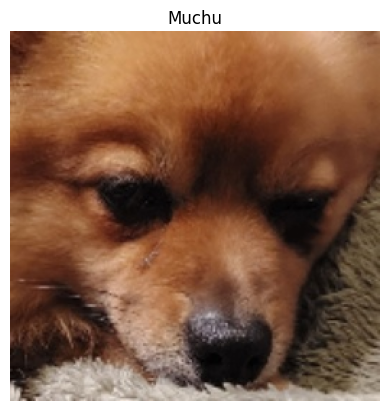

In [7]:
#verify test images on databases

def verify(image_path, database, model):
    encoding = model.predict(load_image(image_path))
    min_dist = float('inf')
    identity = None
    for name, db_enc in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name         
    return min_dist, identity

image = load_image(X_test[0])
print(verify(X_test[0], databaseEllie, model))
print(verify(X_test[0], databaseMarley, model))
print(verify(X_test[0], databaseMuchu, model))



def classify(image_path, model):
    distances = {}
    for database in [databaseEllie, databaseMarley, databaseMuchu]:
        dist, identity = verify(image_path, database, model)
        distances[identity] = dist
    
    name = ''.join([i for i in min(distances, key=distances.get) if not i.isdigit()]).split("_")[0]
    return name


#plot img   
plt.imshow(image[0])
plt.axis("off")
plt.title(classify(X_test[0], model))
plt.show()


embeddings in database for Ellie: 40
embeddings in database for Marley: 39
embeddings in database for Muchu: 51


Text(0.5, 1.0, 'Number of embeddings in each database')

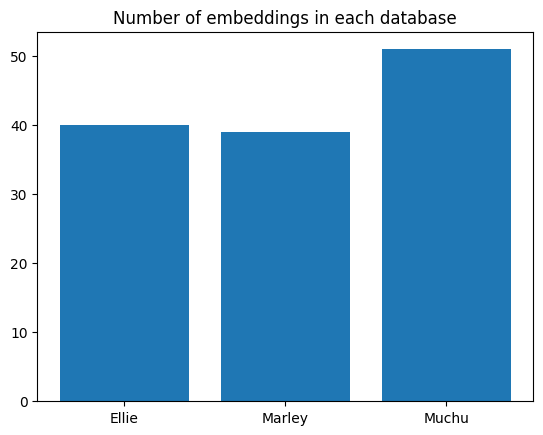

In [8]:
print(f"embeddings in database for Ellie: {len(databaseEllie.items())}")
print(f"embeddings in database for Marley: {len(databaseMarley.items())}")
print(f"embeddings in database for Muchu: {len(databaseMuchu.items())}")

plt.bar(['Ellie', 'Marley', 'Muchu'], [len(databaseEllie.items()), len(databaseMarley.items()), len(databaseMuchu.items())])
plt.title("Number of embeddings in each database")

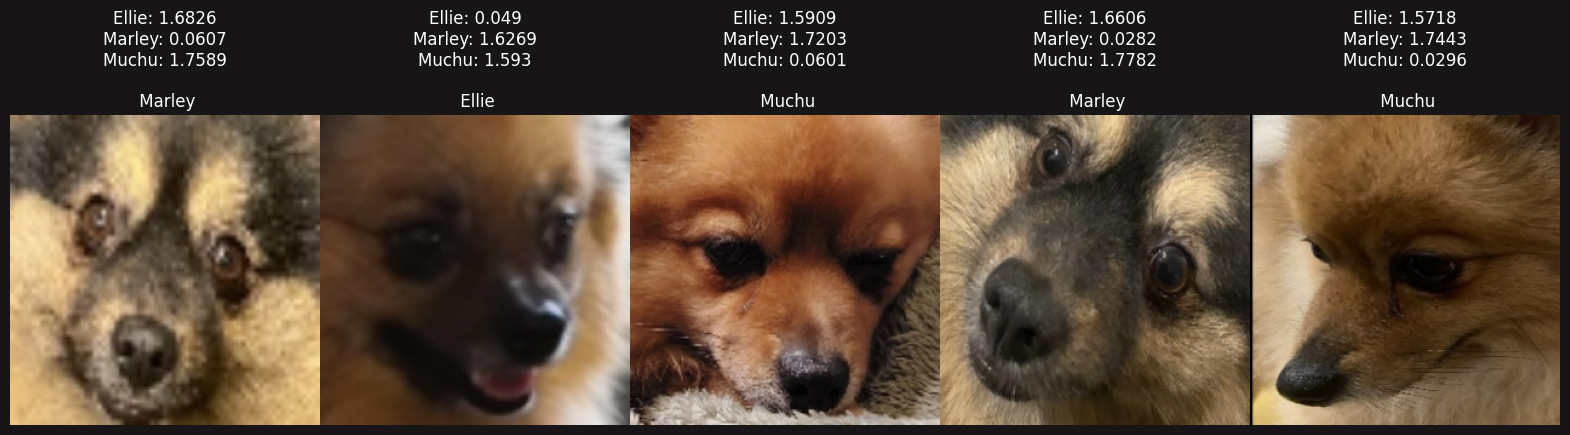

In [59]:

distancesMarley = []
distancesEllie = []
distancesMuchu = []
js = []
for i in range(5):
    j = random.randint(0, len(X_test)-1)
    js.append(j)
    distancesMarley.append(verify(X_test[j], databaseMarley, model))
    distancesEllie.append(verify(X_test[j], databaseEllie, model))
    distancesMuchu.append(verify(X_test[j], databaseMuchu, model))

import random


#do this for 5 images in same plot
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(load_image(X_test[js[i]])[0])
    axs[i].axis("off")
    axs[i].set_title(f"Ellie: {round(float(distancesEllie[i][0]),4)}\nMarley: {round(float(distancesMarley[i][0]),4)}\nMuchu: {round(float(distancesMuchu[i][0]),4)}\n\n {classify(X_test[js[i]], model)}", color='white')
    #remove padding between subplots
    fig.subplots_adjust(wspace=0, hspace=0)
    #change color background to github color
    fig.patch.set_facecolor('#171515')
   
    
plt.show()
#save plot as png
fig.savefig('plot.png', facecolor=fig.get_facecolor(), transparent=True)

    

(1.590893, 'Ellie_17')
(1.7203364, 'Marley_33')
(0.06009403, 'Muchu_45')


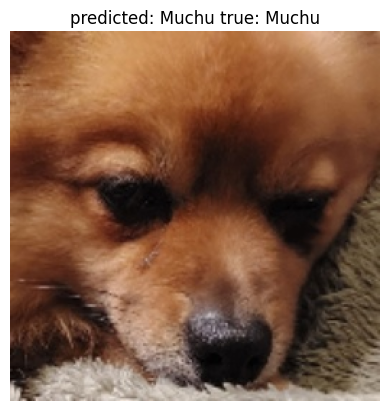

(1.4866238, 'Ellie_17')
(1.8110753, 'Marley_33')
(0.11462247, 'Muchu_38')


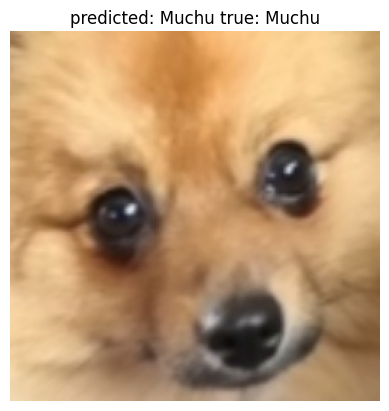

(1.322402, 'Ellie_17')
(1.8906684, 'Marley_33')
(0.35614204, 'Muchu_16')


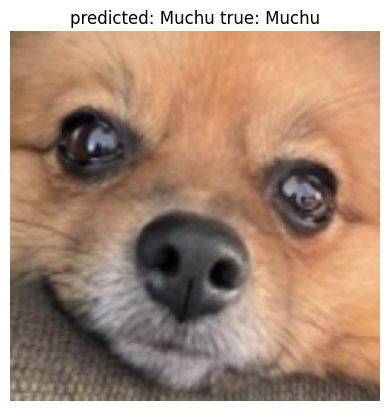

(1.6698625, 'Ellie_2')
(0.048679035, 'Marley_35')
(1.7692125, 'Muchu_48')


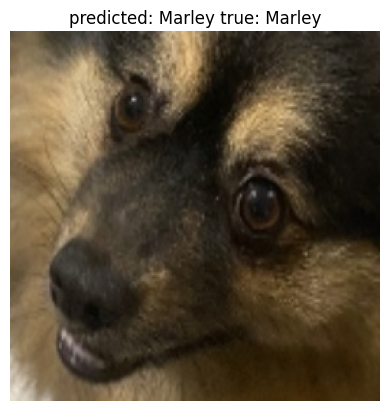

(1.6849045, 'Ellie_2')
(0.031369798, 'Marley_10')
(1.7509733, 'Muchu_48')


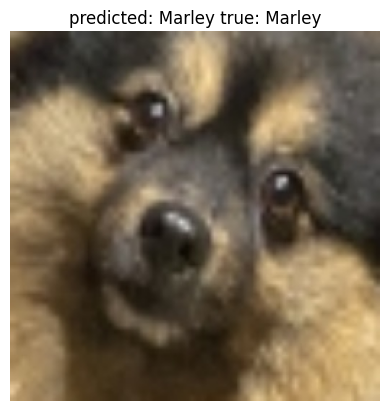

In [11]:
i = 0
for file in X_test:
    i += 1
    if i == 6:
        break
    print(verify(file, databaseEllie, model))
    print(verify(file, databaseMarley, model))
    print(verify(file, databaseMuchu, model))
    
    index = np.where(X_test==file)
    labels = ['Ellie', 'Marley', 'Muchu']
    trueLabel = labels[y_test[index][0]]
    
    image = load_image(file)
    plt.imshow(image[0])
    plt.title(f"predicted: {classify(file, model)} true: {trueLabel}")
    plt.axis("off")
    plt.show()




In [12]:
predictions = []
true_labels = []
misclassified = 0

for file in X_test:
    predictions.append(classify(file, model))
    index = np.where(X_test==file)
    labels = ['Ellie', 'Marley', 'Muchu']
    true_labels.append(labels[y_test[index][0]])
    if classify(file, model) != labels[y_test[index][0]]:
        misclassified += 1

print(f"accuracy: {1-misclassified/len(X_test)}")
print("misclassified: " + str(misclassified) + "/" + str(len(X_test)) + " = " + str(misclassified/len(X_test)))
print("correctly classified: " + str(len(X_test)-misclassified) + "/" + str(len(X_test)) + " = " + str((len(X_test)-misclassified)/len(X_test)))
print("\n")

from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))



accuracy: 1.0
misclassified: 0/33 = 0.0
correctly classified: 33/33 = 1.0


              precision    recall  f1-score   support

       Ellie       1.00      1.00      1.00        10
      Marley       1.00      1.00      1.00         9
       Muchu       1.00      1.00      1.00        14

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [17]:
distance_treshold = 0.5
def verify_with_threshold(image_path, database, model):
    encoding = model.predict(load_image(image_path))
    min_dist = float('inf')
    identity = None
    for name, db_enc in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name
    if min_dist > distance_treshold:
        return min_dist, "unknown"
    else:
        return min_dist, identity

def classify_with_threshold(image_path, model):
    distances = {}
    for database in [databaseEllie, databaseMarley, databaseMuchu]:
        dist, identity = verify_with_threshold(image_path, database, model)
        distances[identity] = dist
    name = ''.join([i for i in min(distances, key=distances.get) if not i.isdigit()]).split("_")[0]
    return name

predictions = []
true_labels = []
misclassified = 0

for file in X_test:
    predictions.append(classify_with_threshold(file, model))
    index = np.where(X_test==file)
    labels = ['Ellie', 'Marley', 'Muchu']
    true_labels.append(labels[y_test[index][0]])
    if classify_with_threshold(file, model) != labels[y_test[index][0]]:
        misclassified += 1

print(f"accuracy: {1-misclassified/len(X_test)}")
print("misclassified: " + str(misclassified) + "/" + str(len(X_test)) + " = " + str(misclassified/len(X_test)))
print("correctly classified: " + str(len(X_test)-misclassified) + "/" + str(len(X_test)) + " = " + str((len(X_test)-misclassified)/len(X_test)))
print("\n")

from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))



accuracy: 0.8787878787878788
misclassified: 4/33 = 0.12121212121212122
correctly classified: 29/33 = 0.8787878787878788


              precision    recall  f1-score   support

       Ellie       1.00      0.90      0.95        10
      Marley       1.00      1.00      1.00         9
       Muchu       1.00      0.79      0.88        14
     unknown       0.00      0.00      0.00         0

    accuracy                           0.88        33
   macro avg       0.75      0.67      0.71        33
weighted avg       1.00      0.88      0.93        33



c:\Users\viers\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viers\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\viers\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
#add test to database
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

LabelsEllie = get_file_name_for_each_label(X,y, 0)
LabelsMarley = get_file_name_for_each_label(X,y, 1)
LabelsMuchu = get_file_name_for_each_label(X,y, 2)

databaseEllie = create_database(model, LabelsEllie, 0)
databaseMarley = create_database(model, LabelsMarley, 1)
databaseMuchu = create_database(model, LabelsMuchu, 2)

creating database for Ellie 1/50
creating database for Ellie 2/50
creating database for Ellie 3/50
creating database for Ellie 4/50
creating database for Ellie 5/50
creating database for Ellie 6/50
creating database for Ellie 7/50
creating database for Ellie 8/50
creating database for Ellie 9/50
creating database for Ellie 10/50
creating database for Ellie 11/50
creating database for Ellie 12/50
creating database for Ellie 13/50
creating database for Ellie 14/50
creating database for Ellie 15/50
creating database for Ellie 16/50
creating database for Ellie 17/50
creating database for Ellie 18/50
creating database for Ellie 19/50
creating database for Ellie 20/50
creating database for Ellie 21/50
creating database for Ellie 22/50
creating database for Ellie 23/50
creating database for Ellie 24/50
creating database for Ellie 25/50
creating database for Ellie 26/50
creating database for Ellie 27/50
creating database for Ellie 28/50
creating database for Ellie 29/50
creating database for E

embeddings in database for Ellie: 50
embeddings in database for Marley: 48
embeddings in database for Muchu: 65


<BarContainer object of 3 artists>

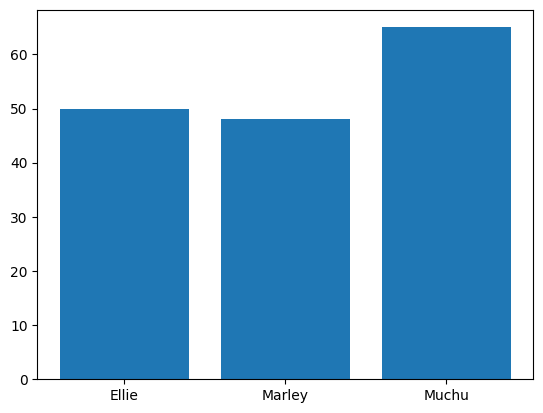

In [15]:
print(f"embeddings in database for Ellie: {len(databaseEllie.items())}")
print(f"embeddings in database for Marley: {len(databaseMarley.items())}")
print(f"embeddings in database for Muchu: {len(databaseMuchu.items())}")

plt.bar(['Ellie', 'Marley', 'Muchu'], [len(databaseEllie.items()), len(databaseMarley.items()), len(databaseMuchu.items())])

#check balance of data

In [16]:
print(databaseEllie)

{'Ellie_1': array([[ 6.99834302e-02,  1.58434406e-01,  6.70789480e-02,
        -8.56125355e-02,  6.39261007e-02,  1.01169772e-01,
        -9.27046686e-02, -9.96183753e-02,  4.98289876e-02,
        -3.04870643e-02, -6.28550947e-02,  1.20693939e-02,
         6.74301237e-02,  6.66745305e-02,  1.13049746e-01,
        -3.94668020e-02,  1.18209101e-01, -9.24390703e-02,
         2.70913810e-01,  7.62571841e-02, -7.91664794e-02,
         7.54128620e-02,  1.06944717e-01,  1.34561770e-02,
        -5.07414974e-02,  1.00791089e-01, -1.83454946e-01,
        -3.38219441e-02, -1.37251005e-01, -9.91127118e-02,
         8.63483772e-02, -1.78747308e-02,  1.82531737e-02,
        -1.17602490e-01,  4.92750891e-02, -1.57136410e-01,
         8.86736438e-02, -6.56441897e-02, -2.90955715e-02,
        -5.01007996e-02, -1.77152862e-03,  1.06475234e-01,
         1.29288398e-02, -2.12915465e-02,  2.84508988e-02,
        -1.09948575e-01,  1.05610052e-02,  3.83594744e-02,
         1.22481257e-01, -7.06812963e-02, -3

In [17]:
#create json file with database
databasePath = "C:\\Users\\viers\\OneDrive\\Bureaublad\\ResearchProject\\researchproject\\training_and_preprocessing\\FaceRecognition\\databases\\"
if not os.path.exists(databasePath):
    os.makedirs(databasePath)

import json

def create_json_file(database, databasePath, name):
    if os.path.exists(databasePath + name + ".json"):
        os.remove(databasePath + name + ".json")
    with open(databasePath + name + ".json", "w+") as file:
        dict_json = ({key: value.tolist() for key, value in database.items()})
        json.dump(dict_json, file)



create_json_file(databaseEllie, databasePath, "databaseEllie")
create_json_file(databaseMarley, databasePath, "databaseMarley")
create_json_file(databaseMuchu, databasePath, "databaseMuchu")

